<a href="https://colab.research.google.com/github/MrCoeg/Age-Of-Early-Universe/blob/main/Unet%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime

%load_ext autotime

from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import cv2
import sys
import gdown

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

sys.path.append("../")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
time: 5.11 s (started: 2023-10-17 13:43:10 +00:00)


In [ ]:
file_id = "1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Dataset.zip'

file_id = "1WoGJ8Q_f2QFs5l05B1sZCFucndAPbgKc"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Rest.zip' -d 'Dataset/rgb'


file_id = "1zGAUdH9UAuh61IaUySWnURXdrNJPdmOQ"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'eval.zip' -d 'Dataset'

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB
To: /content/Dataset.zip
100%|██████████| 390M/390M [00:09<00:00, 39.3MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/rgb/00037591.jpg  
  inflating: Dataset/rgb/00037538.jpg  
  inflating: Dataset/rgb/00037543.jpg  
  inflating: Dataset/rgb/00037547.jpg  
  inflating: Dataset/rgb/00037553.jpg  
  inflating: Dataset/rgb/00037563.jpg  
  inflating: Dataset/rgb/00037549.jpg  
  inflating: Dataset/rgb/00037545.jpg  
  inflating: Dataset/rgb/00037558.jpg  
  inflating: Dataset/rgb/00037562.jpg  
  inflating: Dataset/rgb/00037511.jpg  
  inflating: Dataset/rgb/00037519.jpg  
  inflating: Dataset/rgb/00037542.jpg  
  inflating: Dataset/rgb/00037554.jpg  
  inflating: Dataset/rgb/00037552.jpg  
  inflating: Dataset/rgb/00037615.jpg  
  inflating: Dataset/rgb/00037548.jpg  
  inflating: Dataset/rgb/00037561.jpg  
  inflating: Dataset/rgb/00037555.jpg  
  inflating: Dataset/rgb/00037539.jpg  
  inflating: Dataset/rgb/00037512.jpg  
  inflating: Dataset/rgb/00037520.jpg  
  inflating: Dataset/rgb/00037541.jpg  
  inflating: Dataset/rgb/0003

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1WoGJ8Q_f2QFs5l05B1sZCFucndAPbgKc
To: /content/Rest.zip
100%|██████████| 428M/428M [00:11<00:00, 38.2MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/rgb/00060119.jpg  
  inflating: Dataset/rgb/00060120.jpg  
  inflating: Dataset/rgb/00060121.jpg  
  inflating: Dataset/rgb/00060122.jpg  
  inflating: Dataset/rgb/00060123.jpg  
  inflating: Dataset/rgb/00060124.jpg  
  inflating: Dataset/rgb/00060125.jpg  
  inflating: Dataset/rgb/00060126.jpg  
  inflating: Dataset/rgb/00060127.jpg  
  inflating: Dataset/rgb/00060128.jpg  
  inflating: Dataset/rgb/00060129.jpg  
  inflating: Dataset/rgb/00060130.jpg  
  inflating: Dataset/rgb/00060131.jpg  
  inflating: Dataset/rgb/00060132.jpg  
  inflating: Dataset/rgb/00060133.jpg  
  inflating: Dataset/rgb/00060134.jpg  
  inflating: Dataset/rgb/00060135.jpg  
  inflating: Dataset/rgb/00060136.jpg  
  inflating: Dataset/rgb/00060137.jpg  
  inflating: Dataset/rgb/00060138.jpg  
  inflating: Dataset/rgb/00060139.jpg  
  inflating: Dataset/rgb/00060140.jpg  
  inflating: Dataset/rgb/00060141.jpg  
  inflating: Dataset/rgb/0006

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1zGAUdH9UAuh61IaUySWnURXdrNJPdmOQ
To: /content/eval.zip
100%|██████████| 87.0M/87.0M [00:03<00:00, 24.9MB/s]


Archive:  eval.zip
   creating: Dataset/FreiHAND_pub_v2_eval/
   creating: Dataset/FreiHAND_pub_v2_eval/evaluation/
   creating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000000.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000001.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000002.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000003.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000004.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000005.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000006.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000007.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000008.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000009.jpg  
  inflating: Dataset/FreiHAND_pub_v2_eval/evaluation/rgb/00000010.jpg  
  inflating: Dataset/FreiHAND_pub_

In [ ]:
N_IMG_CHANNELS = 3

MODEL_IMG_SIZE = 128
RAW_IMG_SIZE = 224

DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

time: 632 µs (started: 2023-10-17 13:43:59 +00:00)


In [ ]:
NAMES_KEYPOINTS = [
    "Wrist",
    "Thumb_CMC", "Thumb_MCP", "Thumb_DIP", "Thumb_TIP",
    "Index_MCP", "Index_PIP", "Index_DIP", "Index_TIP",
    "Middle_MCP", "Middle_PIP", "Middle_DIP", "Middle_TIP",
    "Ring_MCP", "Ring_PIP", "Ring_DIP", "Ring_TIP",
    "Pinky_MCP", "Pinky_PIP", "Pinky_DIP", "Pinky_TIP",
]

COLORMAP = {
    "thumb": {"ids": [0,1,2,3,4], "color": "g"},
    "index": {"ids": [0,5,6,7,8], "color": "c"},
    "middle": {"ids": [0,9,10,11,12], "color": "b"},
    "ring": {"ids": [0,13,14,15,16], "color": "m"},
    "little": {"ids": [0,17,18,19,20], "color": "r"},
}

# COLORMAP = {
#      "tip": {"ids": [4,8,12,16,20], "color": "g"},
#      "dip": {"ids": [3,7,11,15,19], "color": "c"},
#      "pip": {"ids": [2,6,10,14,18], "color": "b"},
#      "mcp": {"ids": [0,1,5,9,13,17], "color": "m"},
# }
# Blur Size
FG = 67
FGK = [5.5]

# INDEX_KEYPOINTS = [0,1,5,9,13,17]
# INDEX_KEYPOINTS = [0,2,5,9,13,17]
INDEX_KEYPOINTS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# INDEX_KEYPOINTS = [0,1,2,3,4,5,6,8,9,10,12,13,14,16,17,18,20]

N_KEYPOINTS = len(INDEX_KEYPOINTS)
print(N_KEYPOINTS)
KEYS_KEYPOINTS = [NAMES_KEYPOINTS[i] for i in INDEX_KEYPOINTS]

21
time: 8 ms (started: 2023-10-17 13:54:27 +00:00)


In [ ]:
# Model Tunning Config
train_config = {
    "data_dir": "Dataset",
    "model_neuron": 32,
    "epochs": 1000,
    "batch_size": 16,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 16,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Test Config
test_config = {
    "data_dir": "Dataset/",
    "model_neuron": 8,
    "model_path": "model_final",
    "batch_size": 1,
    "device": torch.device("cuda"),
}

time: 62.9 ms (started: 2023-10-17 13:43:59 +00:00)


In [ ]:
# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)

    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (FG, FG), FGK[0])
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


def CountModelParameter(model):
  parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameter_count


# Loss function IoU

class IoULoss(nn.Module):
    def __init__(self, config):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6
        self.max_euclidean_distance = torch.norm(
            torch.tensor([MODEL_IMG_SIZE, MODEL_IMG_SIZE]).float() -
            torch.tensor([0, 0]).float()
        )
        self.device = config["device"]



    def _op_sum(self, x):
        return x.sum(dim=-1).sum(dim=-1)

    def heatmaps_to_coordinates(self, x):
        # mendapatkan banyak image dalam batch
        batch_size = x.size(0)

        # mendapatkan nilai total dari heatmap width dan height
        sums = x.sum(dim=-1).sum(dim=-1)
        sums = sums.unsqueeze(2).unsqueeze(3)

        # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
        # sehingga hasil berada pada range 0 dan 1
        normalized = (x + self.EPSILON) / (sums+self.EPSILON)

        # mendapatkan nilai total pada normalized heatmap dari width dan height nya
        x_prob = normalized.sum(dim=2)
        y_prob = normalized.sum(dim=3)

        # membuat heatmap baru sebagai kordinat dengan size 0 hingga MODEL_IMG_SIZE - 1
        arr = torch.arange(0, MODEL_IMG_SIZE).float().unsqueeze(0).unsqueeze(1).to(self.device)
        arr = arr.expand(batch_size, N_KEYPOINTS, -1)

        # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
        # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
        x = torch.sum(arr * x_prob, dim=2)
        y = torch.sum(arr * y_prob, dim=2)

        # register kordinat pada tensor
        keypoints = torch.stack([x, y], dim=-1)

        # normaliasasi kembali
        return keypoints / (MODEL_IMG_SIZE - 1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = self._op_sum((y_true ** 2) + (y_pred ** 2) - (y_true * y_pred))
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou



# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, MODEL_IMG_SIZE)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / MODEL_IMG_SIZE

# Visualisasi sample data
def show_data(dataset, n_samples=4 ):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)


        # mendapatkan heatmap image input
        # heatmaps = sample["heatmaps"].numpy()
        plt.imshow(image)
        # mengubah heatmap image input menjadi keypoint
        # input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = sample["input_keypoints"].numpy()
        print(input_keypoints.shape)

        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;
        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
           plt.plot(
               input_keypoints[params["ids"], 0],
               input_keypoints[params["ids"], 1],
               params["color"],
           )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

time: 5.37 ms (started: 2023-10-17 14:15:43 +00:00)


In [ ]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random
import torchvision.transforms.functional as F

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.set_type = set_type
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.eval_image_dir = os.path.join(config["data_dir"] + "/FreiHAND_pub_v2_eval/evaluation", "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))
        self.eval_image_names = np.sort(os.listdir(self.eval_image_dir))
        print(self.eval_image_names)

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]
        self.eval_image_names = [img for img in self.eval_image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]


        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        eval_K_matrix = os.path.join(config["data_dir"]+"/FreiHAND_pub_v2_eval","evaluation_K.json" )
        with open(eval_K_matrix, "r") as f:
            self.eval_K_matrix = np.array(json.load(f))

        eval_anno = os.path.join(config["data_dir"]+"/FreiHAND_pub_v2_eval","evaluation_xyz.json" )
        with open(eval_anno, "r") as f:
            self.eval_anno = np.array(json.load(f))

        # fn_tunning_anno = "keypoint_tuning_xyz.json"
        # with open(fn_tunning_anno, "r") as f:
        #     self.tunning_anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 0
            n_end = 2000
        else:
            n_start = 2000
            n_end = 3000

        self.image_names = self.image_names[n_start:n_end]
        self.eval_image_names = self.eval_image_names[n_start:n_end]
        # self.K_matrix = self.K_matrix[n_start:n_end]
        # self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [

                transforms.ToTensor()
            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor()
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor()
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [

                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
            ]
        )



        self.image_transform_resize = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
            ]
        )

    def __len__(self):
        if self.set_type == "train":
          return len(self.image_names)
        else:
          return len(self.eval_image_names)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        if self.set_type == "train":
          image_name = self.image_names[idx]
          anno_idx = int(image_name[2:8]) % 32560
          image_raw = Image.open(os.path.join(self.image_dir, image_name))

        else:
          image_name = self.eval_image_names[idx]
          anno_idx = int(image_name[2:8])
          image_raw = Image.open(os.path.join(self.eval_image_dir, image_name))

        # instance image menggunakan PIL

        image = self.image_transform_resize(image_raw)

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        if self.set_type == "train":
          keypoints = projectPoints(self.anno[anno_idx], self.K_matrix[anno_idx])
        else :
          keypoints = projectPoints(self.eval_anno[anno_idx], self.eval_K_matrix[anno_idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()
        scale_factor = int(random.random() * 128)

        if scale_factor < 80:
          scale_factor = 80

        crop_pivot = int((128 - scale_factor) / 2)
        rotation_angle = random.random() * 25

        if  self.set_type == "test":
          flip_probability = 0.1
          crop_pivot = 0
          rotation_angle = 0
          scale_factor = 128

        image = F.rotate(image, rotation_angle)
        heatmaps = F.rotate(heatmaps, rotation_angle)

        image = F.resized_crop(image, crop_pivot, crop_pivot, scale_factor, scale_factor , (128, 128), antialias=True)
        heatmaps = F.resized_crop(heatmaps, crop_pivot, crop_pivot, scale_factor, scale_factor , (128, 128),antialias=True)
        # heatmaps = F.resize(heatmaps, (128, 128))

        brightness_factor = torch.FloatTensor(1).uniform_(0.7, 1.2)
        contrast_factor = torch.FloatTensor(1).uniform_(0.5, 1.2)
        saturation_factor = torch.FloatTensor(1).uniform_(0.0, 1.2)
        hue_factor = torch.FloatTensor(1).uniform_(-0.1, 0.1)
        image = F.adjust_brightness(image, brightness_factor)
        image = F.adjust_contrast(image, contrast_factor)
        image = F.adjust_saturation(image, saturation_factor)
        image = F.adjust_hue(image, hue_factor)


        if 0 < flip_probability < 0.25:
          image = self.image_transform(image)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        input_keypoints = heatmaps_to_coordinates(heatmaps.unsqueeze(0).detach().numpy().reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

        keypoints = torch.from_numpy(keypoints)
        input_keypoints = torch.from_numpy(input_keypoints.reshape(42))

        return {
            "image": image,
            "keypoints": keypoints,
            "input_keypoints":input_keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }

time: 5.21 ms (started: 2023-10-17 14:20:48 +00:00)


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
  def __init__(self, in_depth, out_depth):
      super().__init__()
      self.double_conv = nn.Sequential(

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )

      self.skip = nn.Sequential(
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )



  def forward(self, x):
      double_conv = self.double_conv(x)
      skip = self.skip(x)
      return double_conv + skip


class DepthwiseUNet(nn.Module):
  def __init__(self, in_channel, out_channel, model_neurons):
      super().__init__()

      self.normalize = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
      self.maxpool = nn.MaxPool2d(2)
      self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

      self.conv_in = nn.Sequential(
          nn.Conv2d(in_channel, model_neurons, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(model_neurons),
          nn.ReLU(inplace=True),
      )

      # ConvBlock Encoder
      self.conv_down1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons * 2)
      self.conv_down2 = DepthwiseSeparableConvBlock(model_neurons * 2, model_neurons * 4)
      self.conv_down3 = DepthwiseSeparableConvBlock(model_neurons * 4, model_neurons * 8)

      # # Middle
      # self.conv_middle1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons*2)
      # self.conv_middle2 = DepthwiseSeparableConvBlock(model_neurons*2, model_neurons*4)
      # self.conv_middle3 = DepthwiseSeparableConvBlock(model_neurons*4, model_neurons*8)


      # ConvBlock Bottleneck
      self.conv_bottleneck = DepthwiseSeparableConvBlock(model_neurons * 8, model_neurons * 8)


      # ConvBlock Decoder
      self.conv_up1 = DepthwiseSeparableConvBlock(
          model_neurons * 8, model_neurons * 4
      )
      self.conv_up2 = DepthwiseSeparableConvBlock(
          model_neurons * 4, model_neurons * 2
      )
      self.conv_up3 = DepthwiseSeparableConvBlock(
          model_neurons * 2 , model_neurons
      )
      # self.conv_up4 = DepthwiseSeparableConvBlock(
      #     MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
      # )


      # Output layer
      self.conv_out = nn.Sequential(
          nn.Conv2d(model_neurons, out_channel, kernel_size=3, padding=1, bias=False),
          nn.Sigmoid(),
      )



  def forward(self, x):
      #x = self.quant(x)
      x = self.normalize(x)
      conv_re = self.conv_in(x)
      conv_d1 = self.conv_down1(conv_re)
      conv_d2 = self.conv_down2(self.maxpool(conv_d1))
      conv_d3 = self.conv_down3(self.maxpool(conv_d2))

      conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

      conv_u1 = self.conv_up1(self.upsample(conv_b) + conv_d3)
      conv_u2 = self.conv_up2(self.upsample(conv_u1) + conv_d2)
      conv_u3 = self.conv_up3(self.upsample(conv_u2) + conv_d1)
      out = self.conv_out(conv_u3)
      #out = self.dequant(out)
      # post_processed = self.post_processing(dequant)
      return out

time: 9.23 ms (started: 2023-10-17 06:47:07 +00:00)


In [ ]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    """
    Implementation of UNet, slightly modified:
    - less downsampling blocks
    - less neurons in the layers
    - Batch Normalization added

    Link to paper on original UNet:
    https://arxiv.org/abs/1505.04597
    """

    def __init__(self, in_channel, out_channel, MODEL_NEURONS):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        out = self.conv_out(conv_u3)
        return out

time: 1.89 ms (started: 2023-10-17 01:44:11 +00:00)


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
  def __init__(self, in_depth, out_depth):
      super().__init__()
      self.double_conv = nn.Sequential(

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )

      self.skip = nn.Sequential(
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )



  def forward(self, x):
      double_conv = self.double_conv(x)
      skip = self.skip(x)
      return double_conv + skip


class DepthwiseUNet(nn.Module):
  def __init__(self, in_channel, out_channel, model_neurons):
      super().__init__()

      self.normalize = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
      self.maxpool = nn.MaxPool2d(2)
      self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

      self.conv_in = nn.Sequential(
          nn.Conv2d(in_channel, model_neurons, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(model_neurons),
          nn.ReLU(inplace=True),
      )

      # ConvBlock Encoder
      self.conv_down1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons * 2)
      self.conv_down2 = DepthwiseSeparableConvBlock(model_neurons * 2, model_neurons * 4)
      self.conv_down3 = DepthwiseSeparableConvBlock(model_neurons * 4, model_neurons * 8)

      # # Middle
      # self.conv_middle1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons*2)
      # self.conv_middle2 = DepthwiseSeparableConvBlock(model_neurons*2, model_neurons*4)
      # self.conv_middle3 = DepthwiseSeparableConvBlock(model_neurons*4, model_neurons*8)


      # ConvBlock Bottleneck
      self.conv_bottleneck = DepthwiseSeparableConvBlock(model_neurons * 8, model_neurons * 8)


      # ConvBlock Decoder
      self.conv_up1 = DepthwiseSeparableConvBlock(
          model_neurons * 8, model_neurons * 4
      )
      self.conv_up2 = DepthwiseSeparableConvBlock(
          model_neurons * 4, model_neurons * 2
      )

      self.fully_connected = nn.Sequential(
          nn.BatchNorm2d(model_neurons * 2),
          nn.ReLU(inplace=True),
          nn.Flatten(),
          nn.Linear(64*64*model_neurons * 2, 512),
          nn.Dropout(0.3),
          nn.Linear(512, out_channel * 2),
          nn.Sigmoid(),
      )



  def forward(self, x):
      #x = self.quant(x)
      x = self.normalize(x)
      conv_re = self.conv_in(x)
      conv_d1 = self.conv_down1(conv_re)
      conv_d2 = self.conv_down2(self.maxpool(conv_d1))
      conv_d3 = self.conv_down3(self.maxpool(conv_d2))

      conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

      conv_u1 = self.conv_up1(self.upsample(conv_b) + conv_d3)
      conv_u2 = self.conv_up2(self.upsample(conv_u1) + conv_d2)
      # conv_u3 = self.conv_up3(self.upsample(conv_u2) + conv_d1)
      out = self.fully_connected(conv_u2)
      #out = self.dequant(out)
      # post_processed = self.post_processing(dequant)
      return out

time: 2.73 ms (started: 2023-10-17 14:18:47 +00:00)


In [ ]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.best_model = model.state_dict()
        self.best_optimizer = optimizer.state_dict()
        self.current_best_lost = 1
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def save_current_progres(self, path):
        torch.save(self.model.state_dict(), path + "model")
        torch.save(self.optimizer.state_dict(), path + "optimizer")

    def save_best_model(self, path):
        torch.save(self.best_model.state_dict(), path, + "model")
        torch.save(self.best_optimizer.state_dict(), path, + "optimizer")


    def train(self, train_dataloader, val_dataloader, test_dataloader, blur):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )
            # visualisasi testing
            #for data in test_dataloader:
            #    show_batch_predictions(data, model)
            #    break

            #if((epoch+1)%3 == 0 and epoch < 20):
            #    blur[0]= blur[0]- 0.15

            #for g in self.optimizer.param_groups:
            #   g['lr'] = g['lr'] - 0.002

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                # self.scheduler.step(self.loss["train"][-1])
                self.scheduler.step()

            if (self.loss["val"][-1] < self.current_best_lost):
              self.best_model = self.model.state_dict()
              self.best_optimizer = self.optimizer.state_dict()
              self.current_best_lost = self.loss["val"][-1]


            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )
                torch.save(
                    self.optimizer.state_dict(), "optimizer_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            # labels = data["heatmaps"].to(self.device)
            labels = data["input_keypoints"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss

            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())


        # final loss untuk epoch training ini
        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                # labels = data["heatmaps"].to(self.device)
                labels = data["input_keypoints"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                overall_loss = loss

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
            epoch_loss = np.mean(running_loss)
            self.loss["val"].append(epoch_loss)

time: 10.3 ms (started: 2023-10-17 14:21:24 +00:00)


In [ ]:
# membuat training dataset
train_dataset = FreiHAND(config=train_config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

['00000000.jpg' '00000001.jpg' '00000002.jpg' ... '00003957.jpg'
 '00003958.jpg' '00003959.jpg']
time: 2.5 s (started: 2023-10-17 14:21:38 +00:00)


In [ ]:
# membuat eval dataset
val_dataset = FreiHAND(config=train_config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

['00000000.jpg' '00000001.jpg' '00000002.jpg' ... '00003957.jpg'
 '00003958.jpg' '00003959.jpg']
time: 2.58 s (started: 2023-10-17 14:21:31 +00:00)


In [ ]:
# membuat dataset testing
test_dataset = FreiHAND(config=test_config, set_type="test")
test_dataloader = DataLoader(
    test_dataset, test_config["batch_size"], shuffle=True, drop_last=False, num_workers=2,
)

['00000000.jpg' '00000001.jpg' '00000002.jpg' ... '00003957.jpg'
 '00003958.jpg' '00003959.jpg']
time: 5.1 s (started: 2023-10-17 14:21:45 +00:00)


In [ ]:

# membuat model U-Net
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS, train_config["model_neuron"])
model = model.to(train_config["device"])

# membuat loss function
# criterion = IoULoss(train_config)
criterion = nn.MSELoss()
# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=train_config["learning_rate"], nesterov= True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

model.eval()

DepthwiseUNet(
  (normalize): Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_in): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

time: 1.16 s (started: 2023-10-17 14:21:55 +00:00)


In [ ]:
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

<ipython-input-44-fa148bd70f20>:144: RuntimeWarning: invalid value encountered in divide
  normalized = heatmaps / sums


Epoch: 1/1000, Train Loss=nan, Val Loss=nan


KeyboardInterrupt: ignored

time: 7min 29s (started: 2023-10-17 14:21:59 +00:00)


In [ ]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("epoch22model", map_location=torch.device("cpu"))
)
# model = model.to(test_config["device"])

<All keys matched successfully>

time: 89.5 ms (started: 2023-10-17 07:48:10 +00:00)


In [ ]:
# Load the optimizer's state dictionary from the saved file
optimizer_state_dict = torch.load('epoch22optimizer')

# Load the state dictionary into the optimizer
optimizer.load_state_dict(optimizer_state_dict)

time: 53.8 ms (started: 2023-10-16 17:27:48 +00:00)


#FInal 17 32 Neuron 16 Batch Size

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.6554312388, Val Loss=0.6323613496
Epoch: 2/1000, Train Loss=0.6123112271, Val Loss=0.610332437
Epoch: 3/1000, Train Loss=0.5798494959, Val Loss=0.5780380712
Epoch: 4/1000, Train Loss=0.5554353374, Val Loss=0.5527416301
Epoch: 5/1000, Train Loss=0.5372037252, Val Loss=0.5342047853
Epoch: 6/1000, Train Loss=0.5208777499, Val Loss=0.52537289
Epoch: 7/1000, Train Loss=0.5083290458, Val Loss=0.5128285732
Epoch: 8/1000, Train Loss=0.4963836848, Val Loss=0.5005154858
Epoch: 9/1000, Train Loss=0.4871539071, Val Loss=0.4938448377
Epoch: 10/1000, Train Loss=0.4770309161, Val Loss=0.4719695201
Epoch: 11/1000, Train Loss=0.468266404, Val Loss=0.4689270792
Epoch: 12/1000, Train Loss=0.4605960058, Val Loss=0.4607610192


In [ ]:


# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3934624484, Val Loss=0.4006017332
Epoch: 2/1000, Train Loss=0.3938554562, Val Loss=0.4000595689
Epoch: 3/1000, Train Loss=0.3945853754, Val Loss=0.4018216524
Epoch: 4/1000, Train Loss=0.3941485792, Val Loss=0.3996279769
Epoch: 5/1000, Train Loss=0.3940003402, Val Loss=0.3992308688
Epoch: 6/1000, Train Loss=0.3942509584, Val Loss=0.4001538553
Epoch: 7/1000, Train Loss=0.3942691269, Val Loss=0.4024374065
Epoch: 8/1000, Train Loss=0.3944135904, Val Loss=0.4020599518
Epoch: 9/1000, Train Loss=0.3944070036, Val Loss=0.4025472455
Epoch: 10/1000, Train Loss=0.3929461923, Val Loss=0.4011440849
Epoch: 11/1000, Train Loss=0.3939498816, Val Loss=0.4027182136
Epoch: 12/1000, Train Loss=0.3954093275, Val Loss=0.3982803001
Epoch: 13/1000, Train Loss=0.393484844, Val Loss=0.398707149
Epoch: 14/1000, Train Loss=0.3943355661, Val Loss=0.4001419382
Epoch: 15/1000, Train Loss=0.3943017783, Val Loss=0.399150785


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3938172392, Val Loss=0.401920114
Epoch: 2/1000, Train Loss=0.3937583323, Val Loss=0.4008861279
Epoch: 3/1000, Train Loss=0.3930896064, Val Loss=0.3995458608
Epoch: 4/1000, Train Loss=0.3948951035, Val Loss=0.4020172668
Epoch: 5/1000, Train Loss=0.3936515657, Val Loss=0.4013414793
Epoch: 6/1000, Train Loss=0.3929890607, Val Loss=0.4011050177
Epoch: 7/1000, Train Loss=0.3938974658, Val Loss=0.3990605879
Epoch: 8/1000, Train Loss=0.3940974395, Val Loss=0.4002531543
Epoch: 9/1000, Train Loss=0.3941038414, Val Loss=0.4011216736


KeyboardInterrupt: ignored

time: 57min 2s (started: 2023-10-16 16:29:42 +00:00)


In [ ]:
trainer.save_current_progres("epoch5")

time: 94.6 ms (started: 2023-10-16 04:54:20 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)

# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

# eXP

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.785296792, Val Loss=0.7260606236
Epoch: 2/1000, Train Loss=0.7010396561, Val Loss=0.6909729509


KeyboardInterrupt: ignored

time: 4min 56s (started: 2023-10-11 06:30:04 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.852696202, Val Loss=0.7994931149
Epoch: 2/1000, Train Loss=0.7844585298, Val Loss=0.779044939


KeyboardInterrupt: ignored

time: 5min 20s (started: 2023-10-11 06:23:34 +00:00)


In [ ]:
# melakukan testing
# accuracy_all_image = []
# accuracy_per_keypoint = [0] * N_KEYPOINTS

true_keypoints_np = np.zeros((1000, 17, 2))
predicted_keypoints_np = np.zeros((1000, 17, 2))
counter = 0

for data in tqdm(test_dataloader):
    inputs = data["image"]
    # inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()

    true_keypoints_np[counter] = data["keypoints"].numpy()
    predicted_keypoints_np[counter] = heatmaps_to_coordinates(pred_heatmaps)
    counter += 1
    # batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    # for accuracy_keypoint in batched_accuracy_keypoint:
    #   accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    # accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    # accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]

time: 3min 57s (started: 2023-10-17 07:48:59 +00:00)


In [ ]:
errors = np.linalg.norm(predicted_keypoints_np-true_keypoints_np, axis = -1)
mpjpe = np.mean(errors)
mpjpe

0.07781801581985351

time: 10.9 ms (started: 2023-10-17 07:41:06 +00:00)


In [ ]:
vertex_errors = np.linalg.norm(np.mean(predicted_keypoints_np,axis=-1) - np.mean(true_keypoints_np,axis = -1), axis=-1)
mpvpe = np.mean(vertex_errors)
mpvpe

0.19491889004675983

time: 10.9 ms (started: 2023-10-17 07:41:12 +00:00)


In [ ]:
errors = np.linalg.norm(predicted_keypoints_np-true_keypoints_np, axis = -1)
mpjpe = np.mean(errors)
mpjpe

0.09307853226239346

time: 7.31 ms (started: 2023-10-17 07:52:57 +00:00)


In [ ]:
vertex_errors = np.linalg.norm(np.mean(predicted_keypoints_np,axis=-1) - np.mean(true_keypoints_np,axis = -1), axis=-1)
mpvpe = np.mean(vertex_errors)
mpvpe

0.21367116153185833

time: 7.2 ms (started: 2023-10-17 07:52:57 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:30<00:00, 32.34it/s]

time: 30.9 s (started: 2023-10-17 01:56:29 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:33<00:00, 29.89it/s]

time: 33.5 s (started: 2023-10-17 02:03:20 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.18443018, 0.14521889, 0.14944597, 0.17918805, 0.19541486,
       0.12645569, 0.14278517, 0.1640633 , 0.20391615, 0.10770407,
       0.14165949, 0.16060497, 0.1773376 , 0.1261043 , 0.15327788,
       0.18264885, 0.18548894, 0.15070341, 0.17473214, 0.19828746,
       0.19823634])

time: 6.24 ms (started: 2023-10-17 01:53:21 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.09386154, 0.08450829, 0.09959959, 0.11002957, 0.15521661,
       0.06494483, 0.08190567, 0.11590748, 0.05101708, 0.05923092,
       0.0962856 , 0.0686599 , 0.06972499, 0.11007974, 0.09639769,
       0.10327278, 0.13511873])

time: 3.8 ms (started: 2023-10-17 01:57:15 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.07298218, 0.06558791, 0.07910103, 0.08882442, 0.12578067,
       0.08083117, 0.07768677, 0.08635197, 0.04349317, 0.04871234,
       0.05592603, 0.08001415, 0.05683166, 0.05790923, 0.06948598,
       0.09303428, 0.07883524, 0.08516187, 0.09509264, 0.11303663])

time: 3.56 ms (started: 2023-10-17 02:04:01 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.15239137])

time: 4.18 ms (started: 2023-10-11 06:22:35 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.16347202])

time: 4.88 ms (started: 2023-10-11 06:29:19 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.14568156])

time: 3.63 ms (started: 2023-10-11 06:35:27 +00:00)


# More Dataser

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7133630749, Val Loss=0.6457657824
Epoch: 2/1000, Train Loss=0.62258949, Val Loss=0.6123578117
Epoch: 3/1000, Train Loss=0.5872138992, Val Loss=0.5796946938
Epoch: 4/1000, Train Loss=0.5631845646, Val Loss=0.5618236263
Epoch: 5/1000, Train Loss=0.5444395006, Val Loss=0.5464838457
Epoch: 6/1000, Train Loss=0.5297485159, Val Loss=0.5331177938
Epoch: 7/1000, Train Loss=0.5167594418, Val Loss=0.513832474
Epoch: 8/1000, Train Loss=0.5050137865, Val Loss=0.5134699678
Epoch: 9/1000, Train Loss=0.494764768, Val Loss=0.4880386593
Epoch: 10/1000, Train Loss=0.4856092717, Val Loss=0.4825912569
Epoch: 11/1000, Train Loss=0.4775467099, Val Loss=0.473808357
Epoch: 12/1000, Train Loss=0.4697264501, Val Loss=0.4782428448
Epoch: 13/1000, Train Loss=0.4639205499, Val Loss=0.4622754657
Epoch: 14/1000, Train Loss=0.4579897935, Val Loss=0.4664628637
Epoch: 15/1000, Train Loss=0.4521680385, Val Loss=0.4575832732
Epoch: 16/1000, Train Loss=0.4466586601, Val Loss=0.4459829731
Epoch:

KeyboardInterrupt: ignored

time: 3h 6min 45s (started: 2023-10-10 15:54:25 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3976528608, Val Loss=0.4123415644
Epoch: 2/1000, Train Loss=0.3949075972, Val Loss=0.4094649656
Epoch: 3/1000, Train Loss=0.3911954249, Val Loss=0.3999030507
Epoch: 4/1000, Train Loss=0.3894980554, Val Loss=0.391889029
Epoch: 5/1000, Train Loss=0.3859538544, Val Loss=0.3971350465
Epoch: 6/1000, Train Loss=0.3846079679, Val Loss=0.3887204628
Epoch: 7/1000, Train Loss=0.3810388174, Val Loss=0.3940036206
Epoch: 8/1000, Train Loss=0.378283813, Val Loss=0.3865982959
Epoch: 9/1000, Train Loss=0.3765995453, Val Loss=0.3828663538
Epoch: 10/1000, Train Loss=0.3734514359, Val Loss=0.3820479321
Epoch: 11/1000, Train Loss=0.371355864, Val Loss=0.3802628713
Epoch: 12/1000, Train Loss=0.3692328366, Val Loss=0.3829125056
Epoch: 13/1000, Train Loss=0.3670439605, Val Loss=0.3698507564


KeyboardInterrupt: ignored

time: 1h 24min 10s (started: 2023-10-10 19:04:25 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3654933447, Val Loss=0.366150866
Epoch: 2/1000, Train Loss=0.3631480956, Val Loss=0.36779269
Epoch: 3/1000, Train Loss=0.3605264631, Val Loss=0.3661519642
Epoch: 4/1000, Train Loss=0.3588736611, Val Loss=0.3643376894
Epoch: 5/1000, Train Loss=0.3568106945, Val Loss=0.3625844302
Epoch: 6/1000, Train Loss=0.3553662923, Val Loss=0.3574051168
Epoch: 7/1000, Train Loss=0.3529716977, Val Loss=0.3632417667
Epoch: 8/1000, Train Loss=0.351323403, Val Loss=0.3522266526
Epoch: 9/1000, Train Loss=0.3508243311, Val Loss=0.3537698851


In [ ]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("TipWrist", map_location=torch.device("cuda"))
)
model = model.to(test_config["device"])

trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.4333120489, Val Loss=0.4363042502


KeyboardInterrupt: ignored

time: 13min 50s (started: 2023-10-10 11:53:50 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]

time: 32.9 s (started: 2023-10-10 20:28:46 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.05172642, 0.11969761, 0.08792944, 0.07768831, 0.08774968,
       0.11473042])

time: 6.6 ms (started: 2023-10-10 09:16:32 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.05048464, 0.10795463, 0.08224605, 0.07018171, 0.08182552,
       0.10610363])

time: 10.6 ms (started: 2023-10-10 19:01:55 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.04619153, 0.10412088, 0.07496556, 0.06449108, 0.07624739,
       0.09768446])

time: 7.01 ms (started: 2023-10-10 20:29:19 +00:00)


In [ ]:
torch.save(model.state_dict(),"TipWrist")

time: 22.8 ms (started: 2023-10-10 20:30:12 +00:00)


In [ ]:
torch.save(optimizer.state_dict(),"TipWristOp")

time: 24.3 ms (started: 2023-10-10 20:30:15 +00:00)


# Final Tip Index

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.8179517012, Val Loss=0.7768268349
Epoch: 2/1000, Train Loss=0.7498073348, Val Loss=0.7467095685
Epoch: 3/1000, Train Loss=0.7206110278, Val Loss=0.7161181295
Epoch: 4/1000, Train Loss=0.7020934733, Val Loss=0.6992238934
Epoch: 5/1000, Train Loss=0.6891096638, Val Loss=0.6983729646
Epoch: 6/1000, Train Loss=0.6784070483, Val Loss=0.6883886304
Epoch: 7/1000, Train Loss=0.6681618025, Val Loss=0.6713729353
Epoch: 8/1000, Train Loss=0.6619442331, Val Loss=0.6481297069
Epoch: 9/1000, Train Loss=0.6546787285, Val Loss=0.6617491488
Epoch: 10/1000, Train Loss=0.647109913, Val Loss=0.6822944305
Epoch: 11/1000, Train Loss=0.6427873303, Val Loss=0.635619374
Epoch: 12/1000, Train Loss=0.6360476849, Val Loss=0.6365651054
Epoch: 13/1000, Train Loss=0.6298899278, Val Loss=0.6233190501
Epoch: 14/1000, Train Loss=0.6246722158, Val Loss=0.6286566546
Epoch: 15/1000, Train Loss=0.6211681866, Val Loss=0.6262075527
Epoch: 16/1000, Train Loss=0.6155093572, Val Loss=0.6135160623
Epo

In [ ]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("Index_tip_80", map_location=torch.device("cuda"))
)
model = model.to(test_config["device"])

time: 130 ms (started: 2023-10-03 09:04:05 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.5388800482, Val Loss=0.5424048111
Epoch: 2/1000, Train Loss=0.5376003402, Val Loss=0.521891669
Epoch: 3/1000, Train Loss=0.5356976204, Val Loss=0.5327953825
Epoch: 4/1000, Train Loss=0.5338588379, Val Loss=0.5347990558
Epoch: 5/1000, Train Loss=0.5317754026, Val Loss=0.5265003395
Epoch: 6/1000, Train Loss=0.530447757, Val Loss=0.5256239395
Epoch: 7/1000, Train Loss=0.5287177406, Val Loss=0.5205950372
Epoch: 8/1000, Train Loss=0.5262459499, Val Loss=0.5259465387
Epoch: 9/1000, Train Loss=0.5246892364, Val Loss=0.5227024193
Epoch: 10/1000, Train Loss=0.519817417, Val Loss=0.525574748
Epoch: 11/1000, Train Loss=0.52236994, Val Loss=0.543952915
Epoch: 12/1000, Train Loss=0.5203241653, Val Loss=0.5356160066
Epoch: 13/1000, Train Loss=0.5200354226, Val Loss=0.518758146
Epoch: 14/1000, Train Loss=0.5157771095, Val Loss=0.5195291359
Epoch: 15/1000, Train Loss=0.5148382656, Val Loss=0.5159552338
Epoch: 16/1000, Train Loss=0.5142988677, Val Loss=0.5140993986
Epoch: 17

KeyboardInterrupt: ignored

time: 1h 7min 22s (started: 2023-10-03 06:46:08 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.4865914464, Val Loss=0.5060386162
Epoch: 2/1000, Train Loss=0.4856987164, Val Loss=0.4951936722
Epoch: 3/1000, Train Loss=0.4839398224, Val Loss=0.4960190363
Epoch: 4/1000, Train Loss=0.4816077931, Val Loss=0.4859120021
Epoch: 5/1000, Train Loss=0.4789783615, Val Loss=0.5095515091
Epoch: 6/1000, Train Loss=0.4755928439, Val Loss=0.4921847618
Epoch: 7/1000, Train Loss=0.4770357182, Val Loss=0.4832431035
Epoch: 8/1000, Train Loss=0.4733339745, Val Loss=0.5042307699
Epoch: 9/1000, Train Loss=0.469733043, Val Loss=0.4883134842
Epoch: 10/1000, Train Loss=0.4698657455, Val Loss=0.4869222097
Epoch: 11/1000, Train Loss=0.4673031548, Val Loss=0.4819419301
Epoch: 12/1000, Train Loss=0.4646351936, Val Loss=0.4935718379
Epoch: 13/1000, Train Loss=0.4658286497, Val Loss=0.4749884706
Epoch: 14/1000, Train Loss=0.463474191, Val Loss=0.4741489687
Epoch: 15/1000, Train Loss=0.4587513235, Val Loss=0.475111197
Epoch: 16/1000, Train Loss=0.4586719782, Val Loss=0.4766548479
Epoc

KeyboardInterrupt: ignored

time: 35min 14s (started: 2023-10-03 07:56:45 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.4490512892, Val Loss=0.461347487
Epoch: 2/1000, Train Loss=0.4473877035, Val Loss=0.4666398723
Epoch: 3/1000, Train Loss=0.4480089451, Val Loss=0.4589513974
Epoch: 4/1000, Train Loss=0.4473806313, Val Loss=0.4643768592
Epoch: 5/1000, Train Loss=0.4443691882, Val Loss=0.4592501199
Epoch: 6/1000, Train Loss=0.4469211781, Val Loss=0.4548105495
Epoch: 7/1000, Train Loss=0.448645396, Val Loss=0.4585731118
Epoch: 8/1000, Train Loss=0.4457987432, Val Loss=0.4655809019
Epoch: 9/1000, Train Loss=0.4463228788, Val Loss=0.4615714297
Epoch: 10/1000, Train Loss=0.4468600467, Val Loss=0.4623270192
Epoch: 11/1000, Train Loss=0.4456702257, Val Loss=0.4548573947
Epoch: 12/1000, Train Loss=0.4476319905, Val Loss=0.4589970906
Epoch: 13/1000, Train Loss=0.4463227529, Val Loss=0.4655799685
Epoch: 14/1000, Train Loss=0.4469294575, Val Loss=0.4607683349
Epoch: 15/1000, Train Loss=0.4456622405, Val Loss=0.4635142515
Epoch: 16/1000, Train Loss=0.4470076461, Val Loss=0.4628755934
Epo

KeyboardInterrupt: ignored

time: 40min 10s (started: 2023-10-03 09:04:09 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:18<00:00, 53.11it/s]

time: 18.8 s (started: 2023-10-03 08:32:42 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.10411745])

time: 3.56 ms (started: 2023-10-03 06:44:18 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.09416385])

time: 6.3 ms (started: 2023-10-03 07:54:01 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.08747989])

time: 4.98 ms (started: 2023-10-03 08:33:03 +00:00)


#Final Tip

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.8001164015, Val Loss=0.7635650175
Epoch: 2/1000, Train Loss=0.7422776996, Val Loss=0.732098386
Epoch: 3/1000, Train Loss=0.7153305822, Val Loss=0.7157024891
Epoch: 4/1000, Train Loss=0.6957052723, Val Loss=0.6964834855
Epoch: 5/1000, Train Loss=0.6816934058, Val Loss=0.6739966862
Epoch: 6/1000, Train Loss=0.6700852267, Val Loss=0.6668549578
Epoch: 7/1000, Train Loss=0.6583870039, Val Loss=0.6560483415
Epoch: 8/1000, Train Loss=0.6495957304, Val Loss=0.663135844
Epoch: 9/1000, Train Loss=0.6418840751, Val Loss=0.6508989866
Epoch: 10/1000, Train Loss=0.6338676481, Val Loss=0.6450698783
Epoch: 11/1000, Train Loss=0.6269214506, Val Loss=0.6429864063
Epoch: 12/1000, Train Loss=0.6202941118, Val Loss=0.6207994988
Epoch: 13/1000, Train Loss=0.6122250768, Val Loss=0.6114185052
Epoch: 14/1000, Train Loss=0.6062881059, Val Loss=0.6012572105
Epoch: 15/1000, Train Loss=0.602332392, Val Loss=0.6239858327
Epoch: 16/1000, Train Loss=0.5944588433, Val Loss=0.5942453263
Epoc

KeyboardInterrupt: ignored

time: 1h 7min 20s (started: 2023-10-03 02:32:48 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.549842415, Val Loss=0.5744658279
Epoch: 2/1000, Train Loss=0.5470192166, Val Loss=0.5499533167
Epoch: 3/1000, Train Loss=0.5429347276, Val Loss=0.5446159368
Epoch: 4/1000, Train Loss=0.5402947474, Val Loss=0.5554567125
Epoch: 5/1000, Train Loss=0.5350246662, Val Loss=0.5524738345
Epoch: 6/1000, Train Loss=0.5315253693, Val Loss=0.555729214
Epoch: 7/1000, Train Loss=0.5289354708, Val Loss=0.5373146613
Epoch: 8/1000, Train Loss=0.5246199783, Val Loss=0.5363161991
Epoch: 9/1000, Train Loss=0.5245676323, Val Loss=0.5348583372
Epoch: 10/1000, Train Loss=0.5201479428, Val Loss=0.5270906343
Epoch: 11/1000, Train Loss=0.5153504742, Val Loss=0.5330317154
Epoch: 12/1000, Train Loss=0.5141742504, Val Loss=0.5302291722
Epoch: 13/1000, Train Loss=0.5098468413, Val Loss=0.5182157001
Epoch: 14/1000, Train Loss=0.5063674942, Val Loss=0.5271306705
Epoch: 15/1000, Train Loss=0.503877913, Val Loss=0.5170091245
Epoch: 16/1000, Train Loss=0.5023438093, Val Loss=0.5159786587
Epoc

KeyboardInterrupt: ignored

time: 1h 11min 57s (started: 2023-10-03 03:43:25 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:16<00:00, 61.41it/s]

time: 16.3 s (started: 2023-10-03 04:55:27 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.12088672, 0.09182365, 0.07838844, 0.08744079, 0.11354928])

time: 5.59 ms (started: 2023-10-03 04:55:55 +00:00)


# final wrist 16 neuron

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.6190310667, Val Loss=0.5216815953
Epoch: 2/1000, Train Loss=0.4896449182, Val Loss=0.4586458871
Epoch: 3/1000, Train Loss=0.4481425021, Val Loss=0.4348558345
Epoch: 4/1000, Train Loss=0.422735183, Val Loss=0.4064959905
Epoch: 5/1000, Train Loss=0.399026009, Val Loss=0.3815235703
Epoch: 6/1000, Train Loss=0.3832301904, Val Loss=0.3680197647
Epoch: 7/1000, Train Loss=0.3708649077, Val Loss=0.3792887597
Epoch: 8/1000, Train Loss=0.3608150251, Val Loss=0.3439694328
Epoch: 9/1000, Train Loss=0.3479800539, Val Loss=0.334273006
Epoch: 10/1000, Train Loss=0.3410660466, Val Loss=0.3405249636
Epoch: 11/1000, Train Loss=0.3320886281, Val Loss=0.3582024281
Epoch: 12/1000, Train Loss=0.3361485247, Val Loss=0.3289765649
Epoch: 13/1000, Train Loss=0.3298002346, Val Loss=0.3297470777
Epoch: 14/1000, Train Loss=0.3178544276, Val Loss=0.3038988752
Epoch: 15/1000, Train Loss=0.3131025467, Val Loss=0.3103566256
Epoch: 16/1000, Train Loss=0.3097563965, Val Loss=0.2976671267
Epoc

KeyboardInterrupt: ignored

time: 1h 10min 20s (started: 2023-10-03 10:08:28 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.2441066825, Val Loss=0.2535353966
Epoch: 2/1000, Train Loss=0.2427043001, Val Loss=0.2527798958
Epoch: 3/1000, Train Loss=0.2414631809, Val Loss=0.2662015159
Epoch: 4/1000, Train Loss=0.237805049, Val Loss=0.2422340403
Epoch: 5/1000, Train Loss=0.235759345, Val Loss=0.2482084923
Epoch: 6/1000, Train Loss=0.2355744862, Val Loss=0.239591747
Epoch: 7/1000, Train Loss=0.2332628519, Val Loss=0.2350301344
Epoch: 8/1000, Train Loss=0.2277277716, Val Loss=0.2278563054
Epoch: 9/1000, Train Loss=0.2255348266, Val Loss=0.2419768105
Epoch: 10/1000, Train Loss=0.228797589, Val Loss=0.2319040885
Epoch: 11/1000, Train Loss=0.222845763, Val Loss=0.2309216111
Epoch: 12/1000, Train Loss=0.2210981899, Val Loss=0.2330254247
Epoch: 13/1000, Train Loss=0.2188157487, Val Loss=0.2380046787
Epoch: 14/1000, Train Loss=0.2196511923, Val Loss=0.2225354044
Epoch: 15/1000, Train Loss=0.2179656288, Val Loss=0.2265764127
Epoch: 16/1000, Train Loss=0.2137412189, Val Loss=0.2193202415
Epoch:

KeyboardInterrupt: ignored

time: 38min 40s (started: 2023-10-03 11:22:27 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

  1%|          | 8/1000 [00:00<00:44, 22.40it/s]

#Final Wrist 8 Neuron

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.6339783563, Val Loss=0.5441633723
Epoch: 2/1000, Train Loss=0.5112770303, Val Loss=0.4815745606
Epoch: 3/1000, Train Loss=0.4761869614, Val Loss=0.5000883434
Epoch: 4/1000, Train Loss=0.4522160145, Val Loss=0.4672193975
Epoch: 5/1000, Train Loss=0.4333979282, Val Loss=0.4299305511
Epoch: 6/1000, Train Loss=0.4196634885, Val Loss=0.4175105174
Epoch: 7/1000, Train Loss=0.4071922361, Val Loss=0.404631917
Epoch: 8/1000, Train Loss=0.401746383, Val Loss=0.4080361311
Epoch: 9/1000, Train Loss=0.3928575281, Val Loss=0.3942984376
Epoch: 10/1000, Train Loss=0.3823635466, Val Loss=0.3782570632
Epoch: 11/1000, Train Loss=0.3756052138, Val Loss=0.364029876
Epoch: 12/1000, Train Loss=0.3709442268, Val Loss=0.3826282299
Epoch: 13/1000, Train Loss=0.3626220676, Val Loss=0.3687579129
Epoch: 14/1000, Train Loss=0.3561639588, Val Loss=0.3478940272
Epoch: 15/1000, Train Loss=0.3526349228, Val Loss=0.3598004682
Epoch: 16/1000, Train Loss=0.3429112689, Val Loss=0.3438346944
Epoc

# Final 11 32 Neuron

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7211220334, Val Loss=0.6779355118
Epoch: 2/1000, Train Loss=0.6417074765, Val Loss=0.6265587943
Epoch: 3/1000, Train Loss=0.6047405419, Val Loss=0.594728195
Epoch: 4/1000, Train Loss=0.5798307609, Val Loss=0.5839936802
Epoch: 5/1000, Train Loss=0.5621204638, Val Loss=0.5601590273
Epoch: 6/1000, Train Loss=0.546474263, Val Loss=0.5396086531
Epoch: 7/1000, Train Loss=0.5324242588, Val Loss=0.5281728222
Epoch: 8/1000, Train Loss=0.5210905122, Val Loss=0.5177037871
Epoch: 9/1000, Train Loss=0.5096689463, Val Loss=0.5198973048
Epoch: 10/1000, Train Loss=0.4994139369, Val Loss=0.5035696595
Epoch: 11/1000, Train Loss=0.489656757, Val Loss=0.4927572329
Epoch: 12/1000, Train Loss=0.4821178346, Val Loss=0.4821430557
Epoch: 13/1000, Train Loss=0.4741099301, Val Loss=0.4816621842
Epoch: 14/1000, Train Loss=0.4677460732, Val Loss=0.4747967257
Epoch: 15/1000, Train Loss=0.4598178179, Val Loss=0.4579178321
Epoch: 16/1000, Train Loss=0.4540341023, Val Loss=0.4605235813
Epoc

KeyboardInterrupt: ignored

time: 1h 39min 23s (started: 2023-10-02 03:04:16 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.4000107646, Val Loss=0.406854264
Epoch: 2/1000, Train Loss=0.3962010572, Val Loss=0.4103468499
Epoch: 3/1000, Train Loss=0.3926025128, Val Loss=0.3975229189
Epoch: 4/1000, Train Loss=0.3891156521, Val Loss=0.3985844648
Epoch: 5/1000, Train Loss=0.3843499769, Val Loss=0.3920199547
Epoch: 6/1000, Train Loss=0.3802252141, Val Loss=0.3903227415
Epoch: 7/1000, Train Loss=0.3779697586, Val Loss=0.3847016921
Epoch: 8/1000, Train Loss=0.3732723784, Val Loss=0.3855827568
Epoch: 9/1000, Train Loss=0.3692056545, Val Loss=0.3872291522
Epoch: 10/1000, Train Loss=0.3662096911, Val Loss=0.3736650031
Epoch: 11/1000, Train Loss=0.362796811, Val Loss=0.3774478812
Epoch: 12/1000, Train Loss=0.3596666921, Val Loss=0.3715344744


KeyboardInterrupt: ignored

time: 49min 28s (started: 2023-10-02 04:53:25 +00:00)


In [ ]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("11_32neuron", map_location=torch.device("cuda"))
)
model = model.to(test_config["device"])

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3607334287, Val Loss=0.3743291476
Epoch: 2/1000, Train Loss=0.3588904446, Val Loss=0.3725689609
Epoch: 3/1000, Train Loss=0.359451709, Val Loss=0.375289232
Epoch: 4/1000, Train Loss=0.3604021252, Val Loss=0.3743499372
Epoch: 5/1000, Train Loss=0.3600455797, Val Loss=0.3730071769
Epoch: 6/1000, Train Loss=0.3606060314, Val Loss=0.3726662056
Epoch: 7/1000, Train Loss=0.3595942883, Val Loss=0.3765300879


KeyboardInterrupt: ignored

time: 31min 45s (started: 2023-10-02 09:14:33 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(trainer.best_model,"wrist_40")

time: 94.4 ms (started: 2023-10-03 11:19:28 +00:00)


# Final 21 24 Neuron

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

KeyboardInterrupt: ignored

time: 9.1 s (started: 2023-10-02 03:03:27 +00:00)


 #TIP Index

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7439245503, Val Loss=0.6981600318


KeyboardInterrupt: ignored

time: 1min 26s (started: 2023-09-09 01:07:08 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7532942501, Val Loss=0.7183784394
Epoch: 2/1000, Train Loss=0.6831461809, Val Loss=0.6869401667
Epoch: 3/1000, Train Loss=0.6615955593, Val Loss=0.6532256858
Epoch: 4/1000, Train Loss=0.6459455091, Val Loss=0.6686098752
Epoch: 5/1000, Train Loss=0.6292544521, Val Loss=0.6683729305
Epoch: 6/1000, Train Loss=0.6210634367, Val Loss=0.6148992472
Epoch: 7/1000, Train Loss=0.6062062041, Val Loss=0.6105565994
Epoch: 8/1000, Train Loss=0.5978603721, Val Loss=0.5990720375
Epoch: 9/1000, Train Loss=0.5857903848, Val Loss=0.5994297314
Epoch: 10/1000, Train Loss=0.5787620706, Val Loss=0.5597831101
Epoch: 11/1000, Train Loss=0.5699010137, Val Loss=0.5935251975
Epoch: 12/1000, Train Loss=0.5632418093, Val Loss=0.5514651039
Epoch: 13/1000, Train Loss=0.5557284221, Val Loss=0.5557049818


KeyboardInterrupt: ignored

time: 13min 57s (started: 2023-09-08 05:04:33 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.09, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.5461318672, Val Loss=0.5461568933
Epoch: 2/1000, Train Loss=0.5387756149, Val Loss=0.641175168
Epoch: 3/1000, Train Loss=0.5350306615, Val Loss=0.5372229917
Epoch: 4/1000, Train Loss=0.5296945448, Val Loss=0.5302090969
Epoch: 5/1000, Train Loss=0.5272496396, Val Loss=0.5594966683
Epoch: 6/1000, Train Loss=0.5200458656, Val Loss=0.5110540745
Epoch: 7/1000, Train Loss=0.5174820489, Val Loss=0.5382214184
Epoch: 8/1000, Train Loss=0.5129709467, Val Loss=0.522486805
Epoch: 9/1000, Train Loss=0.5089373292, Val Loss=0.5049984517
Epoch: 10/1000, Train Loss=0.5085887191, Val Loss=0.498681278
Epoch: 11/1000, Train Loss=0.4804893513, Val Loss=0.4825446055
Epoch: 12/1000, Train Loss=0.4743228099, Val Loss=0.4843092949
Epoch: 13/1000, Train Loss=0.4702515517, Val Loss=0.4811297891
Epoch: 14/1000, Train Loss=0.4713689421, Val Loss=0.4695234897
Epoch: 15/1000, Train Loss=0.4671555236, Val Loss=0.4649742475


KeyboardInterrupt: ignored

time: 17min 19s (started: 2023-09-08 05:24:38 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:11<00:00, 84.82it/s]

time: 11.8 s (started: 2023-09-08 05:42:03 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.09627464])

time: 4.71 ms (started: 2023-09-08 05:20:05 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.07442533])

time: 9.23 ms (started: 2023-09-08 05:42:31 +00:00)


16 Neuron

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7332010791, Val Loss=0.6777267618
Epoch: 2/1000, Train Loss=0.6625902107, Val Loss=0.6753353677
Epoch: 3/1000, Train Loss=0.63769608, Val Loss=0.6120042105
Epoch: 4/1000, Train Loss=0.6207924514, Val Loss=0.627186795
Epoch: 5/1000, Train Loss=0.6044961742, Val Loss=0.5945202672
Epoch: 6/1000, Train Loss=0.5872868927, Val Loss=0.5665408804
Epoch: 7/1000, Train Loss=0.5745759391, Val Loss=0.5502543786
Epoch: 8/1000, Train Loss=0.5596583395, Val Loss=0.5480798523
Epoch: 9/1000, Train Loss=0.5483446519, Val Loss=0.5445356956
Epoch: 10/1000, Train Loss=0.5409835277, Val Loss=0.5379662564
Epoch: 11/1000, Train Loss=0.5295790588, Val Loss=0.5227747014
Epoch: 12/1000, Train Loss=0.5214382252, Val Loss=0.5136624632
Epoch: 13/1000, Train Loss=0.5168754169, Val Loss=0.5242250845
Epoch: 14/1000, Train Loss=0.5082430855, Val Loss=0.5075300772
Epoch: 15/1000, Train Loss=0.499123281, Val Loss=0.5154627693
Epoch: 16/1000, Train Loss=0.4955739439, Val Loss=0.4924948483


KeyboardInterrupt: ignored

time: 21min 35s (started: 2023-09-08 14:01:37 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3363402263, Val Loss=0.3839317853


KeyboardInterrupt: ignored

time: 1min 26s (started: 2023-09-08 15:10:14 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:16<00:00, 62.15it/s]

time: 16.1 s (started: 2023-09-08 15:11:48 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.08371386])

time: 10.5 ms (started: 2023-09-08 14:23:53 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.08093994])

time: 18.5 ms (started: 2023-09-08 14:36:15 +00:00)


# Full 21

# Final 21 32 Neurn


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7287709905, Val Loss=0.6878458049
Epoch: 2/1000, Train Loss=0.6490593185, Val Loss=0.6371524174
Epoch: 3/1000, Train Loss=0.6101150778, Val Loss=0.6000149415
Epoch: 4/1000, Train Loss=0.5831471125, Val Loss=0.5744771979
Epoch: 5/1000, Train Loss=0.5620188332, Val Loss=0.5570924325
Epoch: 6/1000, Train Loss=0.5454648311, Val Loss=0.5371583922
Epoch: 7/1000, Train Loss=0.5318627927, Val Loss=0.5321243291
Epoch: 8/1000, Train Loss=0.5188905263, Val Loss=0.5295929759
Epoch: 9/1000, Train Loss=0.5076420113, Val Loss=0.5020007119
Epoch: 10/1000, Train Loss=0.4970265538, Val Loss=0.4975007222
Epoch: 11/1000, Train Loss=0.4884530382, Val Loss=0.4970914712
Epoch: 12/1000, Train Loss=0.4796917398, Val Loss=0.4827358534
Epoch: 13/1000, Train Loss=0.4723809356, Val Loss=0.4817774246
Epoch: 14/1000, Train Loss=0.4658445302, Val Loss=0.4669789221
Epoch: 15/1000, Train Loss=0.4599252241, Val Loss=0.4622731068
Epoch: 16/1000, Train Loss=0.4508662166, Val Loss=0.4608306451
E

KeyboardInterrupt: ignored

time: 1h 59min 44s (started: 2023-09-10 10:57:49 +00:00)


In [ ]:

# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.4296281292, Val Loss=0.4360610163
Epoch: 2/1000, Train Loss=0.423754194, Val Loss=0.4306909575
Epoch: 3/1000, Train Loss=0.4187274981, Val Loss=0.4142015843
Epoch: 4/1000, Train Loss=0.4147082512, Val Loss=0.4275020773
Epoch: 5/1000, Train Loss=0.4118914859, Val Loss=0.4339699035
Epoch: 6/1000, Train Loss=0.4065942245, Val Loss=0.4116830654
Epoch: 7/1000, Train Loss=0.4024919177, Val Loss=0.4156534107
Epoch: 8/1000, Train Loss=0.3992236509, Val Loss=0.407507051
Epoch: 9/1000, Train Loss=0.3951011628, Val Loss=0.4102920454
Epoch: 10/1000, Train Loss=0.3917548375, Val Loss=0.4031061528
Epoch: 11/1000, Train Loss=0.390102841, Val Loss=0.3995038354
Epoch: 12/1000, Train Loss=0.3848366659, Val Loss=0.401297894
Epoch: 13/1000, Train Loss=0.3832915874, Val Loss=0.3931113772
Epoch: 14/1000, Train Loss=0.3810961945, Val Loss=0.3918642373
Epoch: 15/1000, Train Loss=0.3773979152, Val Loss=0.3950692198
Epoch: 16/1000, Train Loss=0.3750168207, Val Loss=0.3849312687
Epoch

KeyboardInterrupt: ignored

time: 2h 23min 48s (started: 2023-09-10 12:59:54 +00:00)


In [ ]:
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3328005842, Val Loss=0.3516479447
Epoch: 2/1000, Train Loss=0.3318904808, Val Loss=0.3444705179
Epoch: 3/1000, Train Loss=0.3295005034, Val Loss=0.346273953
Epoch: 4/1000, Train Loss=0.3296366688, Val Loss=0.34275366
Epoch: 5/1000, Train Loss=0.3266380244, Val Loss=0.3489484897
Epoch: 6/1000, Train Loss=0.3255281525, Val Loss=0.3450049577
Epoch: 7/1000, Train Loss=0.3248894784, Val Loss=0.3411740911
Epoch: 8/1000, Train Loss=0.3244211641, Val Loss=0.3428439748
Epoch: 9/1000, Train Loss=0.3224486694, Val Loss=0.3448988426
Epoch: 10/1000, Train Loss=0.3215334022, Val Loss=0.3454720504
Epoch: 11/1000, Train Loss=0.3207139128, Val Loss=0.3434843302


KeyboardInterrupt: ignored

time: 1h 10min 47s (started: 2023-09-10 15:36:38 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.06, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.3248270528, Val Loss=0.3444579813


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:33<00:00, 29.66it/s]

time: 33.7 s (started: 2023-09-10 15:26:50 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.19145665, 0.1446295 , 0.14521277, 0.17491472, 0.18776671,
       0.13191601, 0.14066804, 0.15979707, 0.19721167, 0.11910294,
       0.14805957, 0.16700444, 0.18436203, 0.13525466, 0.161084  ,
       0.19485652, 0.195047  , 0.16093379, 0.18629691, 0.22837458,
       0.21486372])

time: 3.85 ms (started: 2023-10-17 00:19:17 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04968534, 0.04702901, 0.0575104 , 0.06555623, 0.09912479,
       0.05547206, 0.05798538, 0.0752996 , 0.03785005, 0.04068537,
       0.04521898, 0.06807181, 0.04400948, 0.04599401, 0.05345785,
       0.07351   , 0.05846489, 0.06425157, 0.07295173, 0.09196629])

time: 3.85 ms (started: 2023-09-10 15:27:30 +00:00)


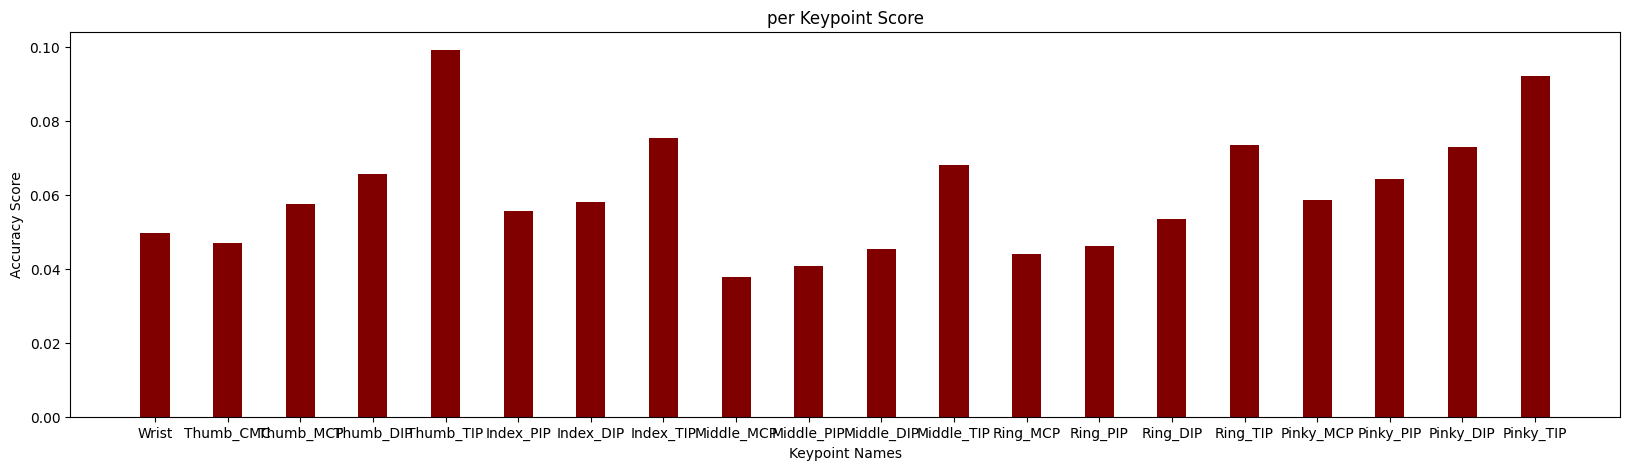

time: 675 ms (started: 2023-09-10 15:34:29 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
torch.save(model.state_dict(),"full 21 epo last")

time: 79.4 ms (started: 2023-09-10 15:24:19 +00:00)


In [ ]:

import matplotlib
# load model
model_test = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS, 32)
model_test.load_state_dict(
    torch.load("ok", map_location=torch.device("cuda"))
)
model_test = model_test.to(train_config["device"])

time: 70.9 ms (started: 2023-09-12 05:34:37 +00:00)


In [ ]:

image_raw = Image.open("aa.jpg")
transform = transforms.Compose(
    [
        transforms.Resize(MODEL_IMG_SIZE),
        transforms.ToTensor(),
    ]

)
image_raw = transform(image_raw)

image_raw = image_raw[None,:, :, :]

image_raw = image_raw.cuda()

time: 152 ms (started: 2023-09-12 05:41:10 +00:00)


(-0.5, 127.5, 127.5, -0.5)

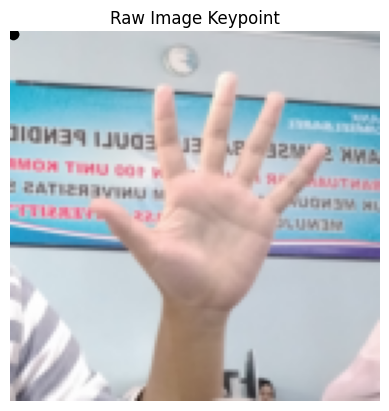

time: 262 ms (started: 2023-09-12 05:50:19 +00:00)


In [ ]:
image_raw = image_raw.cuda()
pred = predictor(image_raw)
image_raw = image_raw.cpu()
pred = pred.cpu()
pred = pred.detach().numpy()
keypoints = pred[0]
plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
images = image_raw.detach().numpy()[0]
images = np.moveaxis(images, 1, -1)
plt.imshow(images)
# for finger, images in COLORMAP.items():
#     plt.plot(
#         pred[params["ids"] * 2 ],
#         pred[(params["ids"] * 2 )+ 1],
#         params["color"],
#     )
plt.title("Raw Image Keypoint")
plt.axis("off")

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7198082203, Val Loss=0.6521631639
Epoch: 2/1000, Train Loss=0.6281713643, Val Loss=0.6098336308
Epoch: 3/1000, Train Loss=0.5984969526, Val Loss=0.5915263729
Epoch: 4/1000, Train Loss=0.5728797342, Val Loss=0.5844727237
Epoch: 5/1000, Train Loss=0.5536641979, Val Loss=0.5641142082
Epoch: 6/1000, Train Loss=0.5236290275, Val Loss=0.5288996565
Epoch: 7/1000, Train Loss=0.5136171249, Val Loss=0.5155713301
Epoch: 8/1000, Train Loss=0.5067228123, Val Loss=0.5067393734
Epoch: 9/1000, Train Loss=0.5010372301, Val Loss=0.50881374
Epoch: 10/1000, Train Loss=0.4942111772, Val Loss=0.4928568053
Epoch: 11/1000, Train Loss=0.4775100297, Val Loss=0.4796845849
Epoch: 12/1000, Train Loss=0.4736847998, Val Loss=0.4768485374
Epoch: 13/1000, Train Loss=0.4695178737, Val Loss=0.4738614717
Epoch: 14/1000, Train Loss=0.4660353926, Val Loss=0.474619637
Epoch: 15/1000, Train Loss=0.4642235415, Val Loss=0.4684545438
Epoch: 16/1000, Train Loss=0.4533658362, Val Loss=0.4597352052
Epoc

In [ ]:
accuracy_per_keypoint /1000

array([0.07660551])

time: 3.75 ms (started: 2023-09-08 14:52:36 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.06879715])

time: 4.48 ms (started: 2023-09-08 15:04:26 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.06740751])

time: 3.63 ms (started: 2023-09-08 15:09:58 +00:00)


In [ ]:
accuracy_per_keypoint /1000

array([0.06754313])

time: 5.27 ms (started: 2023-09-08 15:12:04 +00:00)


In [ ]:
torch.save(model.state_dict(),"24_neuron")

time: 57.8 ms (started: 2023-09-17 11:15:29 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7831042384, Val Loss=0.7708285015
Epoch: 2/1000, Train Loss=0.7219425118, Val Loss=0.7076514187
Epoch: 3/1000, Train Loss=0.6972490311, Val Loss=0.6918818483
Epoch: 4/1000, Train Loss=0.6831214492, Val Loss=0.6675398297
Epoch: 5/1000, Train Loss=0.6722557678, Val Loss=0.665177748
Epoch: 6/1000, Train Loss=0.6634234553, Val Loss=0.6569829047
Epoch: 7/1000, Train Loss=0.6551682957, Val Loss=0.661765914
Epoch: 8/1000, Train Loss=0.6480478002, Val Loss=0.6391001577
Epoch: 9/1000, Train Loss=0.6422121035, Val Loss=0.6371802816


In [ ]:
accuracy_per_keypoint /1000

array([0.07982499])

time: 4.64 ms (started: 2023-09-08 14:45:16 +00:00)


# Full 17

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7086322881, Val Loss=0.643815558
Epoch: 2/1000, Train Loss=0.6225113103, Val Loss=0.6336226912
Epoch: 3/1000, Train Loss=0.5938799675, Val Loss=0.5979229414
Epoch: 4/1000, Train Loss=0.5692082266, Val Loss=0.5756144595
Epoch: 5/1000, Train Loss=0.5510463919, Val Loss=0.5475678511
Epoch: 6/1000, Train Loss=0.5230530126, Val Loss=0.5295302198
Epoch: 7/1000, Train Loss=0.513982741, Val Loss=0.5165069981
Epoch: 8/1000, Train Loss=0.5067889711, Val Loss=0.512121944
Epoch: 9/1000, Train Loss=0.500844243, Val Loss=0.5041777236
Epoch: 10/1000, Train Loss=0.4949786512, Val Loss=0.4961509569
Epoch: 11/1000, Train Loss=0.4775759361, Val Loss=0.4784288611
Epoch: 12/1000, Train Loss=0.4737876177, Val Loss=0.4799704173
Epoch: 13/1000, Train Loss=0.4697215799, Val Loss=0.4770929999
Epoch: 14/1000, Train Loss=0.4672143897, Val Loss=0.470478931
Epoch: 15/1000, Train Loss=0.4637265007, Val Loss=0.4692875853
Epoch: 16/1000, Train Loss=0.4538891056, Val Loss=0.4593014815
Epoch:

KeyboardInterrupt: ignored

time: 1h 44min 15s (started: 2023-08-28 03:03:55 +00:00)


In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7747894035, Val Loss=0.6637516971
Epoch: 2/1000, Train Loss=0.638719479, Val Loss=0.6418460441
Epoch: 3/1000, Train Loss=0.6106165725, Val Loss=0.6048906322
Epoch: 4/1000, Train Loss=0.588310212, Val Loss=0.5782544303
Epoch: 5/1000, Train Loss=0.5681759236, Val Loss=0.5595242858
Epoch: 6/1000, Train Loss=0.5422211449, Val Loss=0.5492844901
Epoch: 7/1000, Train Loss=0.5349856138, Val Loss=0.5361582007
Epoch: 8/1000, Train Loss=0.5277489154, Val Loss=0.5290536623
Epoch: 9/1000, Train Loss=0.5215409834, Val Loss=0.5285743504
Epoch: 10/1000, Train Loss=0.5167135622, Val Loss=0.5429122777
Epoch: 11/1000, Train Loss=0.5026276107, Val Loss=0.5034322691
Epoch: 12/1000, Train Loss=0.4985390746, Val Loss=0.5115537319
Epoch: 13/1000, Train Loss=0.4960570495, Val Loss=0.504438334
Epoch: 14/1000, Train Loss=0.4934235552, Val Loss=0.5012917457
Epoch: 15/1000, Train Loss=0.49015426, Val Loss=0.5036907644
Epoch: 16/1000, Train Loss=0.4816770683, Val Loss=0.4869668694
Epoch:

KeyboardInterrupt: ignored

time: 1h 57min 56s (started: 2023-08-28 06:25:40 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:31<00:00, 31.74it/s]

time: 31.5 s (started: 2023-08-28 08:23:39 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04992343, 0.05460367, 0.06770242, 0.07612914, 0.11452492,
       0.05199544, 0.06127737, 0.08428283, 0.04192853, 0.04404475,
       0.07778254, 0.05309251, 0.05448825, 0.08947213, 0.07349425,
       0.08078087, 0.1109858 ])

time: 9.49 ms (started: 2023-08-28 04:48:42 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.05078757, 0.05888323, 0.0734677 , 0.08283376, 0.12189212,
       0.05423697, 0.06375471, 0.08739498, 0.04498225, 0.04744654,
       0.08744271, 0.05547185, 0.05711828, 0.09701879, 0.07374292,
       0.08021435, 0.1160778 ])

time: 7.42 ms (started: 2023-08-28 08:24:10 +00:00)


In [ ]:
torch.save(model.state_dict(),"full_17")

# Full 11

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7053701338, Val Loss=0.629973891
Epoch: 2/1000, Train Loss=0.6180614686, Val Loss=0.6096929538
Epoch: 3/1000, Train Loss=0.5921196337, Val Loss=0.5789740579
Epoch: 4/1000, Train Loss=0.5670276521, Val Loss=0.5599529114
Epoch: 5/1000, Train Loss=0.5493368686, Val Loss=0.5534483984
Epoch: 6/1000, Train Loss=0.5214018033, Val Loss=0.5182888579
Epoch: 7/1000, Train Loss=0.5131277388, Val Loss=0.519586014
Epoch: 8/1000, Train Loss=0.5058609603, Val Loss=0.514858283
Epoch: 9/1000, Train Loss=0.5002855132, Val Loss=0.5010229406
Epoch: 10/1000, Train Loss=0.4944812466, Val Loss=0.49441273
Epoch: 11/1000, Train Loss=0.4778220702, Val Loss=0.48110797
Epoch: 12/1000, Train Loss=0.4727511859, Val Loss=0.4774924004
Epoch: 13/1000, Train Loss=0.4704760447, Val Loss=0.4725711141
Epoch: 14/1000, Train Loss=0.4668142069, Val Loss=0.4680282426
Epoch: 15/1000, Train Loss=0.4641676813, Val Loss=0.4666155927
Epoch: 16/1000, Train Loss=0.4534400706, Val Loss=0.4576542411
Epoch: 1

KeyboardInterrupt: ignored

time: 1h 8min 18s (started: 2023-08-29 03:28:19 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:20<00:00, 48.03it/s]

time: 20.8 s (started: 2023-08-29 04:36:42 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04541827, 0.07110573, 0.10829717, 0.05189431, 0.0843619 ,
       0.04171528, 0.07295629, 0.05367234, 0.08390692, 0.07340567,
       0.11152563])

time: 3.83 ms (started: 2023-08-29 04:37:11 +00:00)


In [ ]:
torch.save(model.state_dict(),"index")

time: 31.8 ms (started: 2023-09-08 05:42:59 +00:00)


#DIP

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7793825317, Val Loss=0.7213124387
Epoch: 2/1000, Train Loss=0.6943287884, Val Loss=0.6967123163
Epoch: 3/1000, Train Loss=0.6599865412, Val Loss=0.6430344434
Epoch: 4/1000, Train Loss=0.6426500522, Val Loss=0.6245982647
Epoch: 5/1000, Train Loss=0.6222857679, Val Loss=0.6098654292
Epoch: 6/1000, Train Loss=0.6065183286, Val Loss=0.6070369611
Epoch: 7/1000, Train Loss=0.6033480105, Val Loss=0.6079824152
Epoch: 8/1000, Train Loss=0.592940435, Val Loss=0.5946785138
Epoch: 9/1000, Train Loss=0.5821702868, Val Loss=0.5885055661
Epoch: 10/1000, Train Loss=0.5860242392, Val Loss=0.5889547188
Epoch: 11/1000, Train Loss=0.5795571082, Val Loss=0.5827043798
Epoch: 12/1000, Train Loss=0.5735687985, Val Loss=0.5828511856
Epoch: 13/1000, Train Loss=0.5780504563, Val Loss=0.5805526791
Epoch: 14/1000, Train Loss=0.5726157758, Val Loss=0.5658051808
Epoch: 15/1000, Train Loss=0.5687793574, Val Loss=0.5801992216
Epoch: 16/1000, Train Loss=0.5744328463, Val Loss=0.5737713025
Ep

KeyboardInterrupt: ignored

time: 33min 27s (started: 2023-08-24 11:19:06 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.008, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.473463347, Val Loss=0.4968339064


KeyboardInterrupt: ignored

time: 3min 3s (started: 2023-08-24 13:40:35 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.4613131384, Val Loss=0.4818379426
Epoch: 2/1000, Train Loss=0.4613013555, Val Loss=0.4809436932
Epoch: 3/1000, Train Loss=0.4599210992, Val Loss=0.4830674155


KeyboardInterrupt: ignored

time: 5min 40s (started: 2023-08-24 09:31:39 +00:00)


In [ ]:
torch.save(model.state_dict(),"pip_1")

time: 19.9 ms (started: 2023-08-24 15:28:07 +00:00)


In [ ]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("mcp_3", map_location=torch.device("cuda"))
)
model = model.to(test_config["device"])

# membuat loss function
criterion = IoULoss(train_config)

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, nesterov = True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)

time: 244 ms (started: 2023-08-24 17:57:11 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov = True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.5281877719, Val Loss=0.5367818553


KeyboardInterrupt: ignored

time: 3min 33s (started: 2023-08-24 02:03:36 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:20<00:00, 48.33it/s]

time: 20.7 s (started: 2023-08-24 13:43:55 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.12431052, 0.08802582, 0.07392865, 0.09000783, 0.11810665])

time: 9.78 ms (started: 2023-08-23 09:35:43 +00:00)


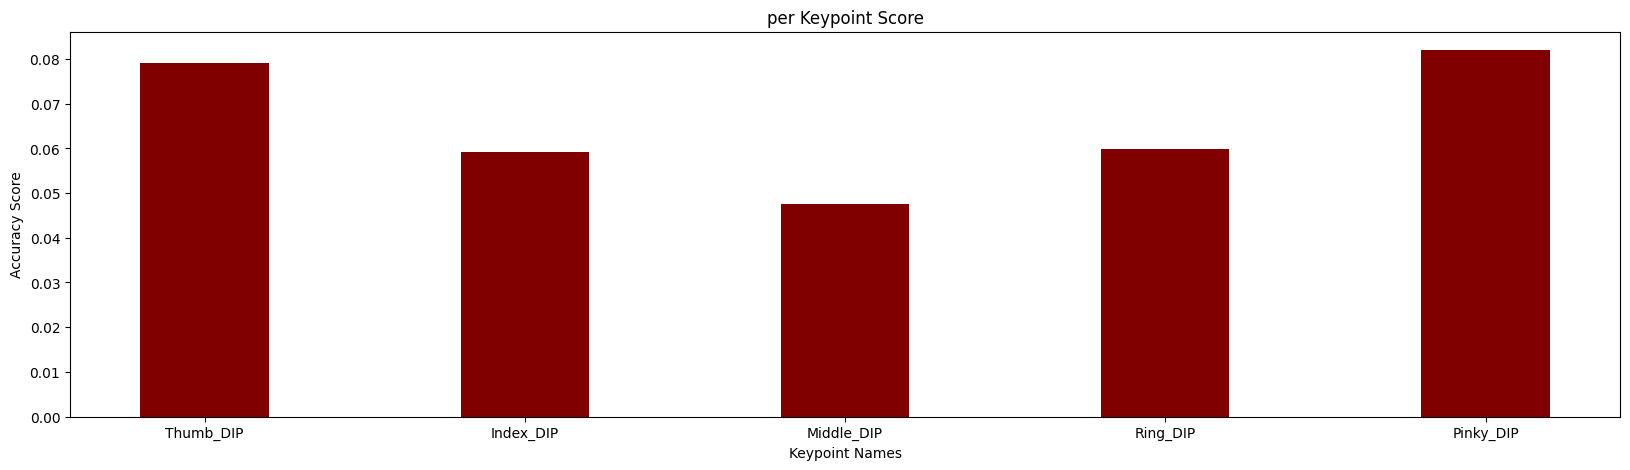

time: 226 ms (started: 2023-08-24 09:14:36 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:

# tunned lr
accuracy_per_keypoint / 1000

array([0.07215997, 0.05745906, 0.04593006, 0.05626675, 0.07761504])

time: 3.68 ms (started: 2023-08-24 13:44:19 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.07149949, 0.05810529, 0.04661782, 0.05682884, 0.0797921 ])

time: 5.6 ms (started: 2023-08-24 12:54:00 +00:00)


In [ ]:

# tunned lr
accuracy_per_keypoint / 1000

array([0.07164364, 0.05668097, 0.04581176, 0.05665978, 0.07738544])

time: 3.91 ms (started: 2023-08-24 09:38:52 +00:00)


#TIP

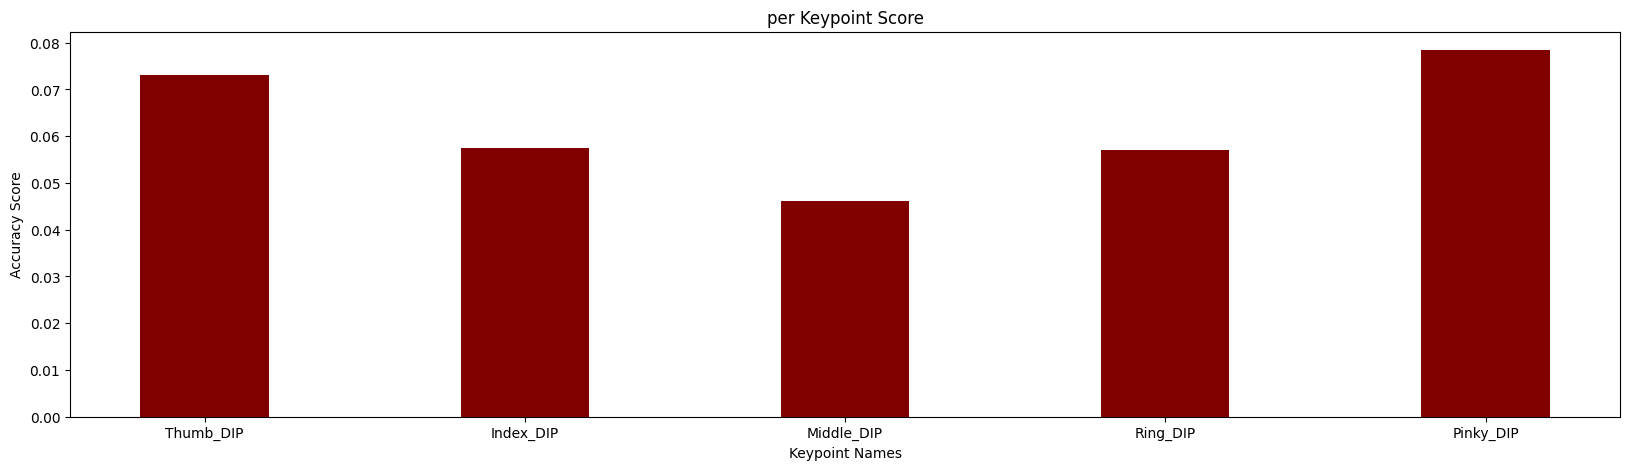

time: 224 ms (started: 2023-08-24 09:15:19 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
accuracy_per_keypoint / 1000

array([0.09906349, 0.07695125, 0.06704245, 0.07525849, 0.09677097])

time: 9.32 ms (started: 2023-08-23 15:05:42 +00:00)


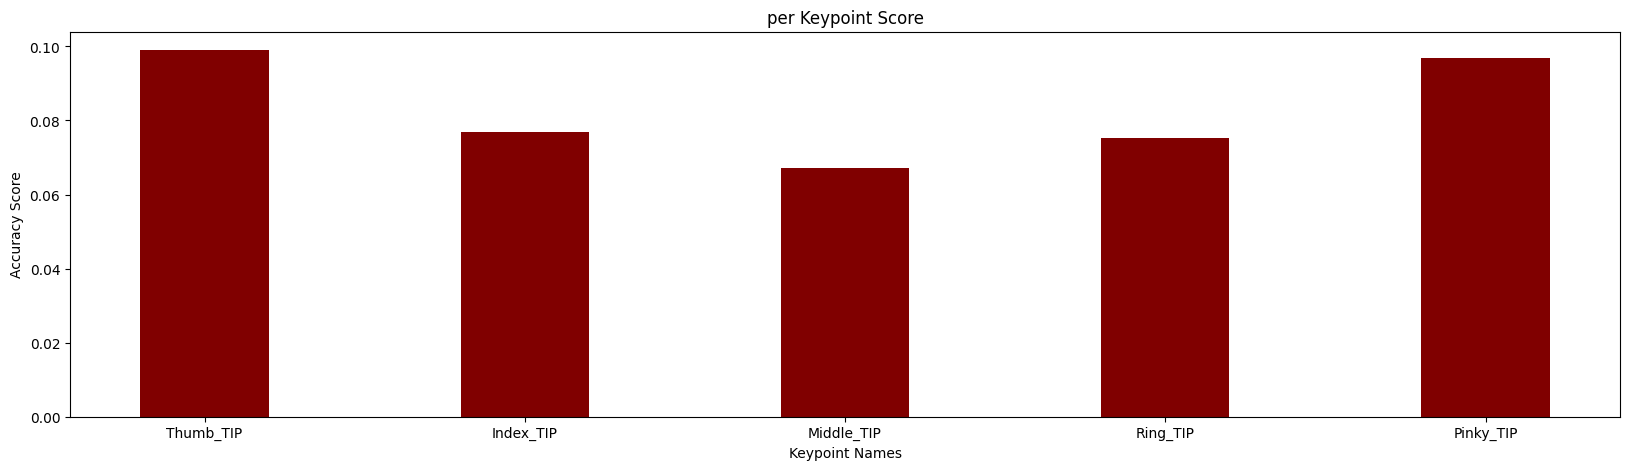

time: 254 ms (started: 2023-08-23 15:06:38 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:18<00:00, 55.06it/s]

time: 18.2 s (started: 2023-08-24 01:53:43 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06653438, 0.05661125, 0.05221586, 0.05312582, 0.05967904])

time: 3.98 ms (started: 2023-08-23 03:11:32 +00:00)


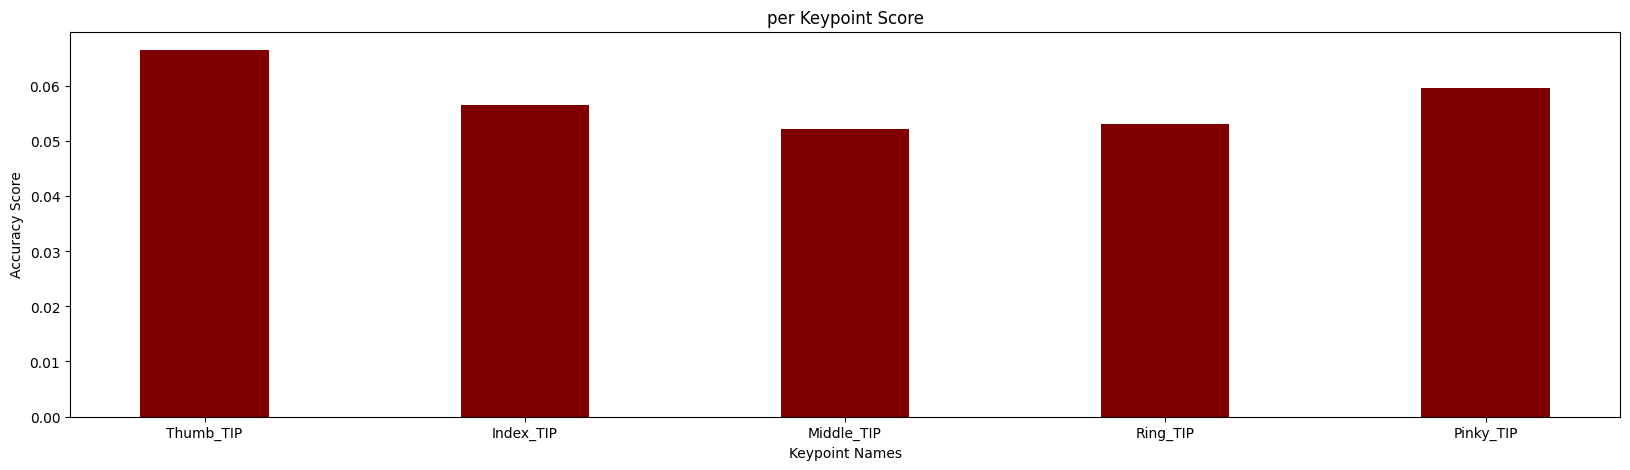

time: 230 ms (started: 2023-08-23 03:11:40 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
accuracy_per_keypoint / 1000

array([0.09863969, 0.07612176, 0.06735832, 0.07607442, 0.09777972])

time: 6.25 ms (started: 2023-08-24 01:54:01 +00:00)


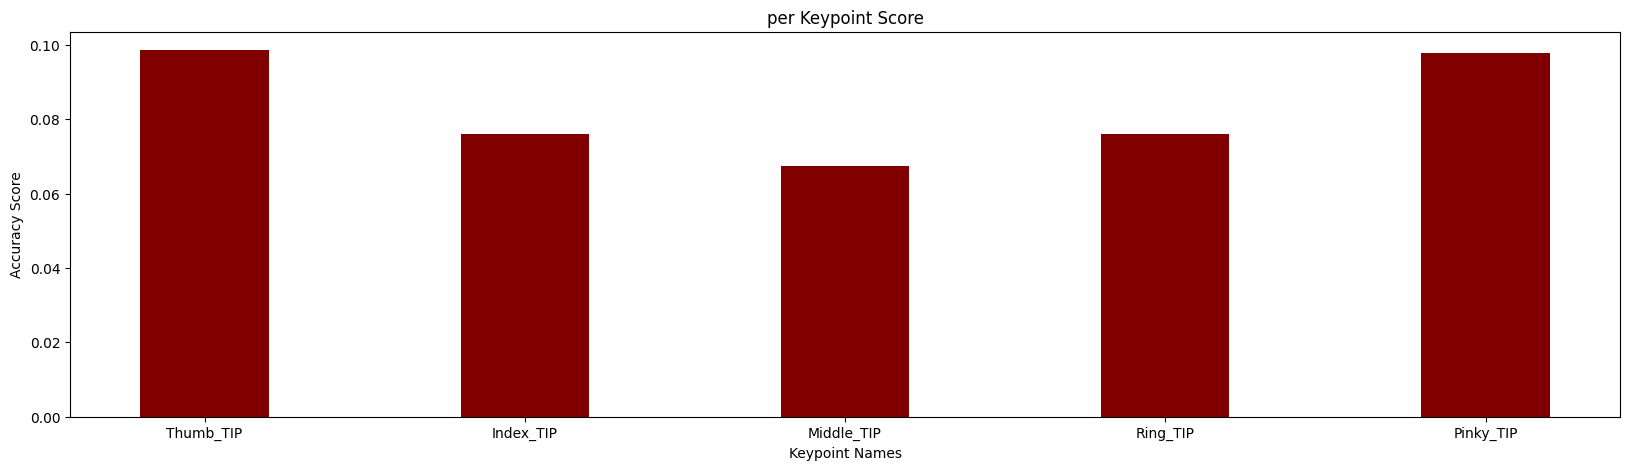

time: 222 ms (started: 2023-08-24 01:54:01 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

#PIP

In [ ]:
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.7711237102, Val Loss=0.7162209086
Epoch: 2/1000, Train Loss=0.693930007, Val Loss=0.6883820014
Epoch: 3/1000, Train Loss=0.6582999013, Val Loss=0.6391760044
Epoch: 4/1000, Train Loss=0.6446601961, Val Loss=0.6449086866
Epoch: 5/1000, Train Loss=0.6256339947, Val Loss=0.6355855999
Epoch: 6/1000, Train Loss=0.6107390803, Val Loss=0.6075806181
Epoch: 7/1000, Train Loss=0.6093098725, Val Loss=0.6105707119
Epoch: 8/1000, Train Loss=0.5996973861, Val Loss=0.610232275
Epoch: 9/1000, Train Loss=0.5894951557, Val Loss=0.5928363047
Epoch: 10/1000, Train Loss=0.5929532, Val Loss=0.6014018884
Epoch: 11/1000, Train Loss=0.5850418263, Val Loss=0.5798715653
Epoch: 12/1000, Train Loss=0.5786598376, Val Loss=0.5858232284
Epoch: 13/1000, Train Loss=0.5852748235, Val Loss=0.60683812
Epoch: 14/1000, Train Loss=0.5794736724, Val Loss=0.5847089448
Epoch: 15/1000, Train Loss=0.5734863333, Val Loss=0.56972995
Epoch: 16/1000, Train Loss=0.582002987, Val Loss=0.5816666965
Epoch: 17/1

KeyboardInterrupt: ignored

time: 39min 27s (started: 2023-08-24 13:51:04 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0005)





# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.4472248588, Val Loss=0.4719563127


KeyboardInterrupt: ignored

time: 2min 3s (started: 2023-08-24 15:46:22 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:17<00:00, 57.32it/s]

time: 17.5 s (started: 2023-08-24 15:48:29 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.07140889, 0.06020003, 0.04530881, 0.05667483, 0.08538977])

time: 3.31 ms (started: 2023-08-24 14:53:34 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06692485, 0.05676869, 0.04231762, 0.05240385, 0.0784732 ])

time: 3.52 ms (started: 2023-08-24 14:58:32 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06565876, 0.05764851, 0.04373759, 0.05393796, 0.07990633])

time: 4.45 ms (started: 2023-08-24 15:08:36 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06645251, 0.05927267, 0.04438709, 0.05313243, 0.076963  ])

time: 6.52 ms (started: 2023-08-24 15:11:55 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06650599, 0.05810557, 0.04430458, 0.05353857, 0.07713674])

time: 13.5 ms (started: 2023-08-24 15:16:15 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.0647199 , 0.05679364, 0.04094215, 0.05045844, 0.07484849])

time: 13.2 ms (started: 2023-08-24 15:22:23 +00:00)


In [ ]:

# savepoint
accuracy_per_keypoint / 1000

array([0.06289315, 0.05492383, 0.04023751, 0.04949156, 0.0716499 ])

time: 4.43 ms (started: 2023-08-24 15:26:19 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06353029, 0.0546512 , 0.04029524, 0.05037591, 0.07255161])

time: 3.8 ms (started: 2023-08-24 15:33:06 +00:00)


In [ ]:

#checkpoint
accuracy_per_keypoint / 1000

array([0.06267029, 0.05446323, 0.04004915, 0.04928404, 0.07096695])

time: 5.14 ms (started: 2023-08-24 15:36:28 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06268717, 0.05459754, 0.0400846 , 0.04929389, 0.07133252])

time: 5.04 ms (started: 2023-08-24 15:40:41 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06262136, 0.05427532, 0.04000085, 0.04917975, 0.07111458])

time: 9.85 ms (started: 2023-08-24 15:45:34 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06271952, 0.05429353, 0.0400398 , 0.04926072, 0.07127592])

time: 7.27 ms (started: 2023-08-24 15:48:46 +00:00)


In [ ]:
torch.save(model.state_dict(),"pip_2")

time: 21.8 ms (started: 2023-08-24 15:37:28 +00:00)


#MCP

In [ ]:
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.4208048884, Val Loss=0.4300514567
Epoch: 2/1000, Train Loss=0.4171412666, Val Loss=0.4249313776
Epoch: 3/1000, Train Loss=0.4154501659, Val Loss=0.4235730293
Epoch: 4/1000, Train Loss=0.4139840151, Val Loss=0.4226138957


KeyboardInterrupt: ignored

time: 9min 15s (started: 2023-08-24 16:44:25 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, nesterov = True, momentum=0.8)
# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.3644034567, Val Loss=0.3806242547


KeyboardInterrupt: ignored

time: 2min 9s (started: 2023-08-24 18:01:00 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:15<00:00, 65.30it/s]

time: 15.3 s (started: 2023-08-24 18:03:19 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04568004, 0.0598823 , 0.05407314, 0.04540911, 0.06401457,
       0.08907964])

time: 8.78 ms (started: 2023-08-24 16:23:00 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04506535, 0.05542493, 0.05242254, 0.04239675, 0.05268514,
       0.07244856])

time: 5.28 ms (started: 2023-08-24 16:34:46 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.04186717, 0.05267775, 0.04963625, 0.03956072, 0.05027707,
       0.07165573])

time: 13 ms (started: 2023-08-24 16:43:34 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.0403948 , 0.04885782, 0.04577711, 0.03726462, 0.0476799 ,
       0.06751434])

time: 4.43 ms (started: 2023-08-24 17:48:22 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.03903153, 0.04830824, 0.0453116 , 0.03627198, 0.04595496,
       0.06443538])

time: 3.51 ms (started: 2023-08-24 17:52:54 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.03934461, 0.04813566, 0.04530917, 0.03620333, 0.04597589,
       0.06436079])

time: 3.61 ms (started: 2023-08-24 18:03:34 +00:00)


In [ ]:
torch.save(model.state_dict(),"mcp_4")

time: 31.9 ms (started: 2023-08-24 18:03:58 +00:00)


#Test

In [ ]:
trainer = Trainer(quantized_model, criterion, optimizer, train_config, scheduler)
# TRaining model
quantized_model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

KeyboardInterrupt: ignored

time: 29.5 s (started: 2023-09-02 07:04:56 +00:00)


In [ ]:
class PostProcessOutput(nn.Module):
  def __init__(self, n_keypoint, heatmap_size):
      super().__init__()
      self.keypoint = n_keypoint
      self.size = heatmap_size

  def heatmaps_to_coordinates(self, heatmaps):

      # mendapatkan banyak image dalam batch
      # heatmaps = heatmaps.cpu()
      # heatmaps = heatmaps.detach().numpy()

      batch_size = heatmaps.shape[0]

      # mendapatkan nilai total dari heatmap width dan height
      sums = heatmaps.sum(dim=[2, 3], keepdim=True)

      # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
      # sehingga hasil berada pada range 0 dan 1
      normalized = heatmaps / sums

      # mendapatkan nilai total pada normalized heatmap dari width dan height nya
      x_prob = normalized.sum(axis=2)
      y_prob = normalized.sum(axis=3)

      # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
      arr = torch.arange(0, self.size, dtype=torch.float32).unsqueeze(0).unsqueeze(1).cuda()
      arr = arr.expand(batch_size, self.keypoint, self.size)


      # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
      # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
      x = (arr * x_prob).sum(axis=2)
      y = (arr * y_prob).sum(axis=2)

      # register kordinat pada array
      keypoints = torch.stack([x, y], dim=-1)
      keypoints = keypoints / self.size

      return keypoints

  def forward(self, x):
      return self.heatmaps_to_coordinates(x)


class KeypointPredictor(nn.Module):
  def __init__(self, in_channel, out_channel, UnetModel):
      super().__init__()
      self.post_processing = PostProcessOutput(out_channel, 128)
      self.unet = UnetModel

  def forward(self, x):
      heatmaps = self.unet.forward(x)
      post_processed = self.post_processing(heatmaps)
      return post_processed

time: 3.19 ms (started: 2023-09-12 05:29:23 +00:00)


In [ ]:


predictor = KeypointPredictor(3, N_KEYPOINTS, model_test)
predictor.eval()

KeypointPredictor(
  (post_processing): PostProcessOutput()
  (unet): DepthwiseUNet(
    (quant): QuantStub()
    (dequant): DeQuantStub()
    (normalize): Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
    (conv_in): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv_down1): DepthwiseSeparableConvBlock(
      (double_conv): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, m

time: 6.4 ms (started: 2023-09-12 05:34:52 +00:00)


In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 37.9 MB/s eta 0:00:00
time: 7.14 s (started: 2023-09-11 14:48:00 +00:00)


In [ ]:
import onnx

time: 25.1 ms (started: 2023-09-11 14:48:07 +00:00)


In [ ]:
import torch
import torch.nn as nn

class DepthwiseSeparableRegressionModel(nn.Module):
    def __init__(self, neur):
        super().__init__()
        # Depthwise separable convolutions for feature extraction
        self.depthwise1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3)  # Depthwise convolution
        self.pointwise1 = nn.Conv2d(3, neur, kernel_size=1)  # Pointwise convolution
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.depthwise2 = nn.Conv2d(neur, neur, kernel_size=3, stride=1, padding=1, groups=16)
        self.pointwise2 = nn.Conv2d(neur, neur*2, kernel_size=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.depthwise3 = nn.Conv2d(neur*2, neur*2, kernel_size=3, stride=1, padding=1, groups=32)
        self.pointwise3 = nn.Conv2d(neur*2, neur*4, kernel_size=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers for regression
        self.fc1 = nn.Linear(neur*8 * neur * neur, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(64, 5)  # Output has 5 dimensions for regression

    def forward(self, x):
        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.depthwise2(x)
        x = self.pointwise2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.depthwise3(x)
        x = self.pointwise3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu4(x)

        x = self.fc2(x)
        x = self.relu5(x)

        x = self.fc3(x)

        return x

# Create an instance of the DepthwiseSeparableRegressionModel
model = DepthwiseSeparableRegressionModel(16)


In [ ]:

dummy_input = torch.randn(1, 3, 128, 128)
dummy_input = dummy_input.to(test_config["device"])
torch.onnx.export(
         predictor,
         dummy_input,
         "Bismillah.onnx",
         export_params=True,
         opset_version=11,
         do_constant_folding=True,
         input_names = ['input'],
         output_names = ['output'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

time: 8.06 s (started: 2023-09-11 14:48:57 +00:00)
